# Working zfourge luminosity function notebook with minimum code

This produces a single luminosity function with one redshift bin

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy.cosmology import FlatLambdaCDM

zmin = 0.1
zmax = 0.9
survey_area = 0.11 # square degrees zfourge
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
mlim = 27 # CDFS apparent magnitude limit

# Read in CDFS main data
data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data)
df = df[df['Use'] == 1]
df = df[df['zpk'] >= zmin]
df = df[df['zpk'] <= zmax]
# df = df[df['FKs'] <= mlim]
print(f'Number of sources: {len(df)}')

z = df['zpk'] # redshift
m_app = df['FKs'] # apparent magnitude

Number of sources: 3867


### Convert apparent magnitude to apparent AB magnitude and then to absolute magnitude

In [4]:
# m-M = 5 log d + 25
dists = cosmo.luminosity_distance(z) * 10 ** 6 # pc
m_ab = 25 - 2.5*np.log10(m_app) # AB magnitude
M_abs = m_ab - 5 * np.log10(dists / 10) # absolute magnitude

C:\Users\n10480129\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Uncorrected

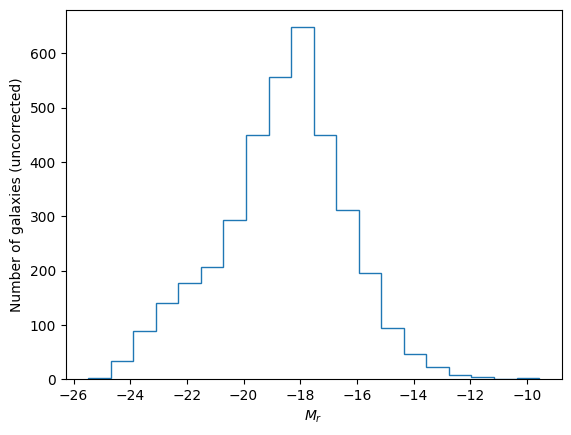

Number of galaxies in each bin: [  2.  33.  89. 140. 178. 206. 294. 449. 557. 648. 450. 311. 195.  94.
  47.  23.   8.   4.   0.   2.]


In [5]:
counts, bin_edges, _ = plt.hist(M_abs, bins=20, histtype='step')
plt.xlabel('$M_r$')
plt.ylabel('Number of galaxies (uncorrected)')
plt.show()
print('Number of galaxies in each bin:', counts)

### Calculate the volume probed in each luminosity bin

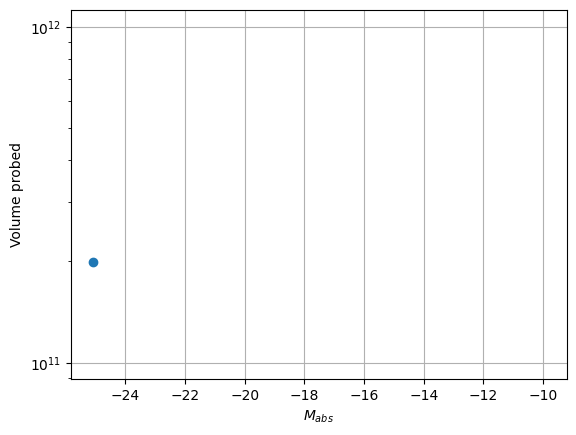

dmaxs: [2.61282854e+05 1.81122757e+05 1.25555323e+05 8.70356619e+04
 6.03336146e+04 4.18236039e+04 2.89923595e+04 2.00976681e+04
 1.39318176e+04 9.65761497e+03 6.69471349e+03 4.64081337e+03
 3.21703816e+03 2.23006910e+03 1.54589655e+03 1.07162426e+03
 7.42856018e+02 5.14952006e+02 3.56967652e+02 2.47452002e+02]
vol: [ 1.99231722e+11  6.63658729e+10  2.21070669e+10  7.36406170e+09
  2.45303445e+09  8.17127229e+08  2.72191862e+08  9.06690046e+07
  3.02021128e+07  1.00600488e+07  3.35054670e+06  1.11555136e+06
  3.71054374e+05  1.23055750e+05  4.04451842e+04  1.29268639e+04
  3.76026461e+03  7.06788179e+02 -3.10352204e+02 -6.49170788e+02]


In [17]:
# Calculate the central value of each luminosity bin
bin_centers = bin_edges[0:-1] + np.diff(bin_edges)[0] / 2

# Calculate the minimum and maximum distance of the redshift bin
dmin = cosmo.comoving_distance(zmin).value # Mpc
dmax = cosmo.comoving_distance(zmax).value

# Calculate the maximum distance of each luminosity bin
dmaxs = (10 * 10 ** ((mlim - bin_centers) / 5)) / 10 ** 6 # Mpc

# If the maximum distance is greater than the maximum redshift bin distance, set it to the maximum redshift bin distance
# dmaxs[dmaxs > dmax] = dmax # Is this necessary?

# Calculate the minimum volume of the redshift bin
vmin = 4/3 * np.pi * dmin**3

# Calculate the maximum volume of each luminosity bin
vmaxs = 4/3 * np.pi * dmaxs**3

# Total volume probed accounting for survey area
vol = (vmaxs - vmin) * survey_area / (41253)

# Plot the volume probed as a function of absolute magnitude
plt.scatter(bin_centers, vol)
plt.yscale('log')
plt.xlabel(r'$M_{abs}$')
plt.ylabel('Volume probed')
plt.grid()
plt.show()

print(f'dmaxs: {dmaxs}')
# print(f'dmin: {dmin}')
# print(f'dmax: {dmax}')
print(f'vol: {vol}')

### Corrected Luminosity Function

Text(0, 0.5, '$log(\\phi$ [Mpc$^{-3}$ $M_{AB}^{-1}$])')

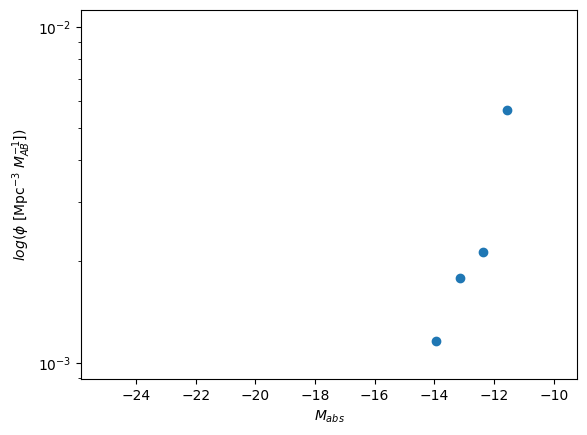

In [18]:
lf = counts / vol
plt.scatter(bin_centers, lf)
plt.yscale('log')
plt.xlabel(r'$M_{abs}$')
plt.ylabel(r'$log(\phi$ [Mpc$^{-3}$ $M_{AB}^{-1}$])')

### Luminosity Function with Schechter fit

M_star: 18.672543334414282
phi_star: 0.0009356370383654524
alpha: 2.9999999999998797


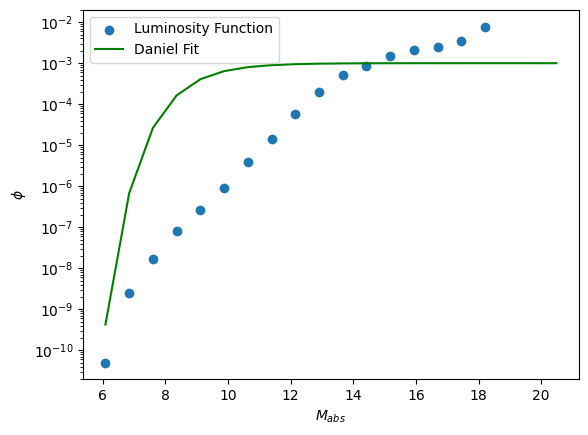

In [7]:
from scipy.optimize import curve_fit

def schechter(M, M_star, phi_star, alpha):
    return phi_star * 10 ** (-0.4*(alpha+1)*(M-M_star)) * np.exp(-10.**(-0.4*(M-M_star)))

p0 = [9, 0.001, -1] # Initial guess for fit parameters
bounds = ([4, 0, -3], [30, 2, 3]) # Bounds for fit parameters
params, covars = curve_fit(schechter, bin_centers, lf, p0=p0, bounds=bounds, maxfev=1000)

print(f'M_star: {params[0]}')
print(f'phi_star: {params[1]}')
print(f'alpha: {params[2]}')

plt.scatter(bin_centers, lf, label='Luminosity Function') # Plot the corrected LF
plt.plot(bin_centers, schechter(bin_centers, *params), color='red', label='Schechter Fit') # Plot the Schechter fit
plt.plot(bin_centers, schechter(bin_centers, *[9, 0.001, -1]), color='green', label='Daniel Fit') # Plot the Schechter fit
plt.xlabel('$M_{abs}$')
plt.ylabel('$\phi$')
plt.yscale('log')
plt.legend()
plt.show()